# Forex Price Forecasting
In this notebook I will obtain historical forex data for the GBP/USD currency pair from an API and then train an LSTM neural network to forecast the price of the pair into the future. We will forecast only a single timestep into the future and use a multi-input and single-output LSTM. The aim will be to predict the close for each day.

In [1]:
import requests
from datetime import datetime, timedelta
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error as mae

## Get GBP/USD Data

In [20]:
with open("api.key", "r") as f:
    API_KEY = f.read()

# The free API only allows us a small request size, so I am actually going to download the data
# separately and read it in but, this demonstrates how I would gather these data
url = f'https://api.polygon.io/v2/aggs/ticker/C:GBPUSD/range/1/day/2023-05-14/2023-06-14?adjusted=true&sort=asc&apiKey={API_KEY}'
r = requests.get(url)
data = r.json()

# Check the call was successful
if data["status"] != "OK":
    print("API call failed")
    print(data["status"])

timestamps = [datetime.fromtimestamp(d['t'] / 1000).strftime('%Y-%m-%d %H:%M:%S') for d in data['results']]

In [3]:
df = pd.read_csv("./data/GBPUSD.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.723811,1.727205,1.718390,1.718597,1.718597,0.0
2003-12-02,1.719010,1.732112,1.717298,1.730313,1.730313,0.0
2003-12-03,1.730493,1.731812,1.725209,1.728101,1.728101,0.0
2003-12-04,1.727414,1.728997,1.718302,1.720697,1.720697,0.0
2003-12-05,1.720608,1.733102,1.719809,1.733102,1.733102,0.0


In [4]:
np.count_nonzero(np.isnan(df['Close'])), len(df)

(17, 5361)

In [5]:
# Drop NaN rows
df.dropna(inplace=True, axis=0)
len(df)

5344

## Plot Data
This we we can quickly see any seasonality or trends. Then we could de-seasonalise or detrend our data.

In [6]:
time_mask = df.index < datetime(2022, 1, 1)
fig = go.Figure(data=[go.Candlestick(x=df[time_mask].index,
                open=df[time_mask]['Open'],
                high=df[time_mask]['High'],
                low=df[time_mask]['Low'],
                close=df[time_mask]['Close'])],
)

fig.update_layout(
    title='GBP/USD Daily Price History',
    yaxis_title='GBP/USD Price',
)
fig.show()

## Build our Training Data

In [7]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime(year=year, month=month, day=day)

def df_to_windowed(dataframe, first_date_str, last_date_str, window_size=5):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X = []
    Y = []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(window_size + 1)

        if len(df_subset) != window_size+1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1] # x is the last window_size close values

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break
            
        target_date = next_date
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    X = np.array(X)
    for i in range(0, window_size):
        X[:, i]
        ret_df[f'Target-{window_size-i}'] = X[:, i]
    ret_df['Target'] = Y
    return ret_df


In [8]:
df_close_only = pd.DataFrame(df['Close'])

windowed_df = df_to_windowed(df_close_only, '2003-12-08', '2024-06-17')
windowed_df.head()

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2003-12-08,1.718597,1.730313,1.728101,1.720697,1.733102,1.734214
1,2003-12-09,1.730313,1.728101,1.720697,1.733102,1.734214,1.745414
2,2003-12-10,1.728101,1.720697,1.733102,1.734214,1.745414,1.739796
3,2003-12-11,1.720697,1.733102,1.734214,1.745414,1.739796,1.746206
4,2003-12-12,1.733102,1.734214,1.745414,1.739796,1.746206,1.747305


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1] # features (does not include the target)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # (timesteps, window_size, n_features)
    # We are using 1 feature i.e. the last window_size close values
    Y = df_as_np[:, -1] # Targets (close values)
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((5339,), (5339, 5, 1), (5339,))

Split into a training validation and test set, note we must do this in order since we want to forecast into the future, no random shuffling here.

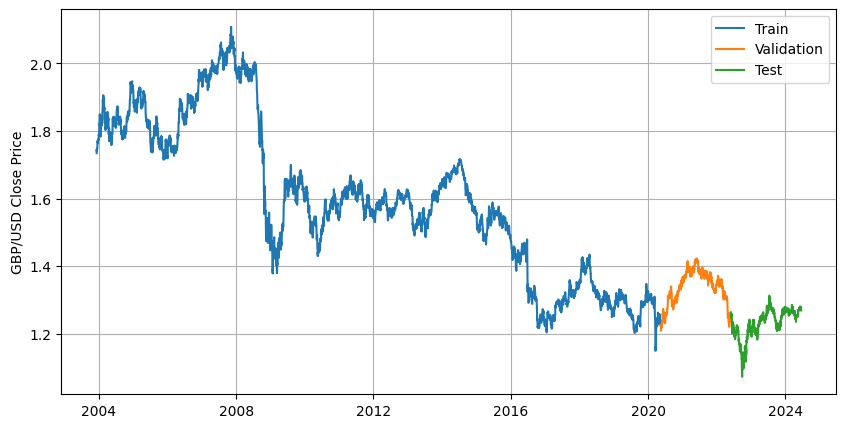

In [10]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(10, 5))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.ylabel("GBP/USD Close Price")
plt.legend(['Train', 'Validation', 'Test'])
plt.grid()
plt.show()

## Training our Model

In [11]:
window_size = X.shape[1]
n_features = X.shape[2]

model = Sequential()
model.add(InputLayer((window_size, n_features)))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

checkpoint_callback = ModelCheckpoint('models/gbpusd_forex_lstm.keras', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])

2024-06-18 18:26:59.328603: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-18 18:26:59.328624: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-18 18:26:59.328634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-18 18:26:59.329289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 18:26:59.329603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, callbacks=[checkpoint_callback])

Epoch 1/60


2024-06-18 18:27:08.646145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1891 - mean_absolute_error: 1.0198 - val_loss: 0.0036 - val_mean_absolute_error: 0.0592
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0311 - val_loss: 0.0017 - val_mean_absolute_error: 0.0402
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0279 - val_loss: 0.0012 - val_mean_absolute_error: 0.0330
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8706e-04 - mean_absolute_error: 0.0256 - val_loss: 0.0012 - val_mean_absolute_error: 0.0325
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.5014e-04 - mean_absolute_error: 0.0237 - val_loss: 8.0124e-04 - val_mean_absolute_error: 0.0266
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.7886e-04 - mean_absolute_error: 0.0211 - val_loss: 6.5915e-04 - val_mean_absolute_error: 0.0239
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.4792e-04 - mean_absolu

## Evaluate Training

In [14]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame({'predictions': predictions, 'actuals': y})
    plt.figure(figsize=(10, 5))
    plt.plot(df['predictions'][start:end], label="Predictions")
    plt.plot(df['actuals'][start:end], label="Actual")
    plt.grid()
    plt.legend()
    plt.show()

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


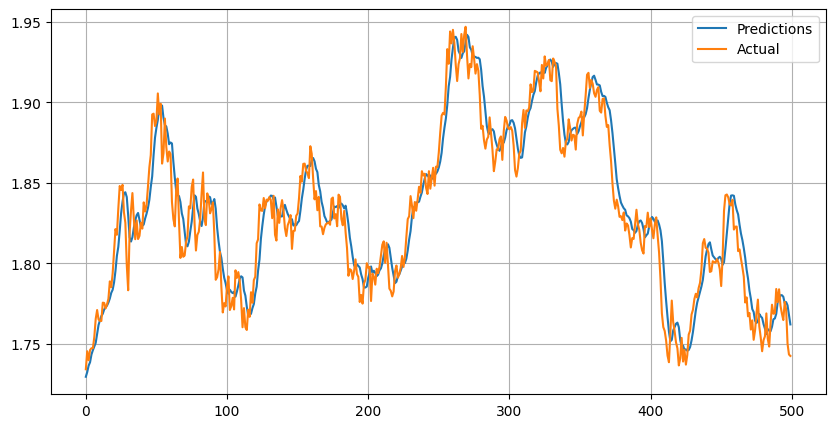

In [15]:
plot_predictions(model, X_train, y_train, start=0, end=500)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


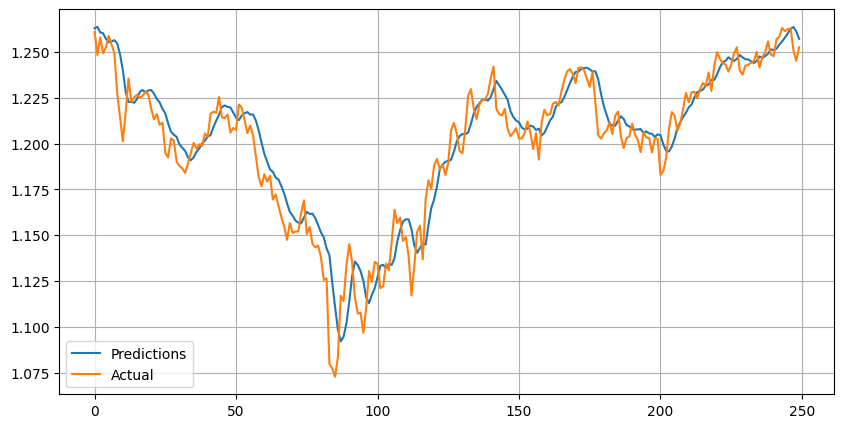

In [16]:
plot_predictions(model, X_test, y_test, start=0, end=250)

Clearly this has worked reasonably nicely, but we can probably improve by adding more features to our model! The above was just a univariate forecast. Now we move to a multivariate forecast.

# Multivariate Input for Single-Output

In [36]:
df = df.drop(["Adj Close", "Volume"], axis=1)
df.head()

KeyError: "['Adj Close', 'Volume'] not found in axis"

In [37]:
df['CloseMav7'] = df['Close'].rolling(
    window=7,
    min_periods=3,
    center=True
).mean()

df['CloseMav30'] = df['Close'].rolling(
    window=30,
    min_periods=15,
    center=True
).mean()

In [39]:
def df_to_X_y_multivariate(df, window_size=5): # Changed window size as using 5 variables just so we can see shape diff.
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]] # Rows of data
        X.append(row)
        y.append(df_as_np[i+window_size][0]) # COuld forecast multi-variables here but we don't
    return np.array(X), np.array(y)

In [40]:
X, y = df_to_X_y_multivariate(df, window_size=7)
X.shape, y.shape

((5337, 7, 6), (5337,))

In [41]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [42]:
window_size = X.shape[1]
n_features = X.shape[2]

# Same architecture as before
model = Sequential()
model.add(InputLayer((window_size, n_features)))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

checkpoint_callback = ModelCheckpoint('models/gbpusd_forex_lstm_multivariate.keras', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,449 (95.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, callbacks=[checkpoint_callback])

Epoch 1/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.1277 - mean_absolute_error: 1.3887 - val_loss: 4.0741e-04 - val_mean_absolute_error: 0.0159
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0144 - mean_absolute_error: 0.0949 - val_loss: 0.0122 - val_mean_absolute_error: 0.1095
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0089 - mean_absolute_error: 0.0781 - val_loss: 0.0094 - val_mean_absolute_error: 0.0959
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0071 - mean_absolute_error: 0.0697 - val_loss: 0.0066 - val_mean_absolute_error: 0.0805
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0601 - val_loss: 0.0048 - val_mean_absolute_error: 0.0682
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0489 - val_loss: 0.0028 - val_mean_absolute_error: 0.0522
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mean_absolute_error:

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


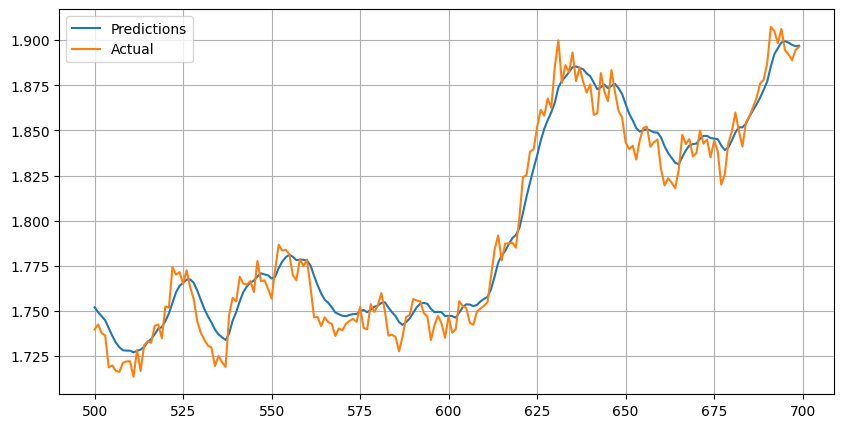

In [44]:
plot_predictions(model, X_train, y_train, start=500, end=700)

In [45]:
mean_absolute_error(y_train, model.predict(X_train))

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.008786986680454406

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


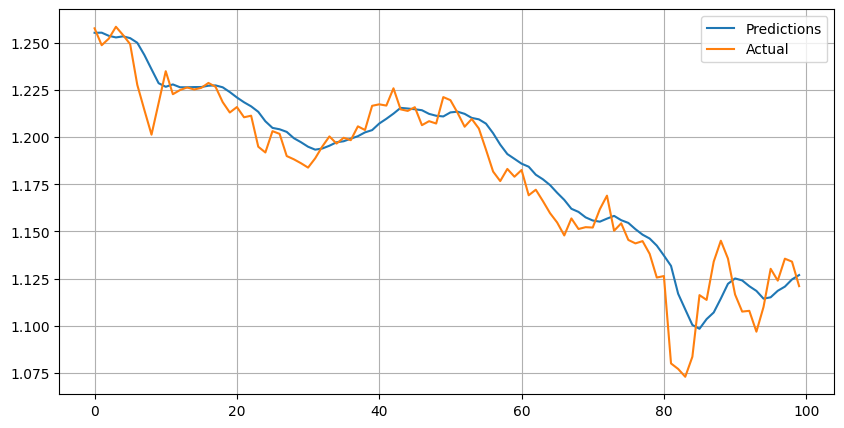

In [46]:
plot_predictions(model, X_test, y_test)

In [47]:
mean_absolute_error(y_test, model.predict(X_test))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.006691356845210368

## Adding more Features
We may find the that GBP/USD price is highly correlated with the GBP/EUR price. For example, it may be likely that when the pound falls against the euro it also falls against the dollar (the sign of a weakening pound).

In [58]:
df2 = pd.read_csv("./data/GBPEUR.csv", index_col="Date", parse_dates=["Date"])
df2.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
df2.columns = ["OpenEUR", "HighEUR", "LowEUR", "CloseEUR"]
len(df2)

5415

In [59]:
df2.dropna(inplace=True, axis=0)
len(df2)

5386

In [65]:
# Concatenate the dataframes together, joining on the date index
dfx = pd.concat([df, df2], axis=1)
dfx.dropna(inplace=True, axis=0)
dfx.head()

,Open,High,Low,Close,CloseMav7,CloseMav30,OpenEUR,HighEUR,LowEUR,CloseEUR
Date,,,,,,,,,,
2003-12-01,1.723811,1.727205,1.718390,1.718597,1.724427,1.743131,1.4327,1.4405,1.4323,1.4366
2003-12-02,1.719010,1.732112,1.717298,1.730313,1.726162,1.744453,1.4368,1.4399,1.4297,1.4308
2003-12-03,1.730493,1.731812,1.725209,1.728101,1.727504,1.745615,1.4306,1.4322,1.4249,1.4251
2003-12-04,1.727414,1.728997,1.718302,1.720697,1.730063,1.747280,1.4253,1.4300,1.4190,1.4242
2003-12-05,1.720608,1.733102,1.719809,1.733102,1.733091,1.748761,1.4243,1.4265,1.4194,1.4213


In [66]:
X, y = df_to_X_y_multivariate(df, window_size=7)
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [74]:
window_size = X.shape[1]
n_features = X.shape[2]

# Same architecture as before
model = Sequential()
model.add(InputLayer((window_size, n_features)))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

checkpoint_callback = ModelCheckpoint('models/gbpusd_forex_lstm_multivariate_v2.keras', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, callbacks=[checkpoint_callback])

Epoch 1/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.4165 - mean_absolute_error: 1.1026 - val_loss: 0.0268 - val_mean_absolute_error: 0.1622
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0150 - mean_absolute_error: 0.1011 - val_loss: 0.0157 - val_mean_absolute_error: 0.1238
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0116 - mean_absolute_error: 0.0885 - val_loss: 0.0110 - val_mean_absolute_error: 0.1038
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0072 - mean_absolute_error: 0.0700 - val_loss: 0.0050 - val_mean_absolute_error: 0.0694
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - mean_absolute_error: 0.0448 - val_loss: 9.2461e-04 - val_mean_absolute_error: 0.0285
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.0974e-04 - mean_absolute_error: 0.0207 - val_loss: 1.1359e-04 - val_mean_absolute_error: 0.0082
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.9145e-04 - mean_abs

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


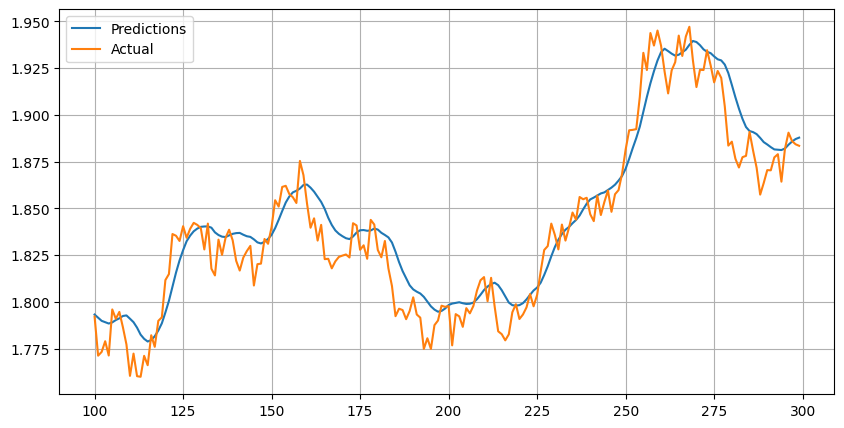

In [75]:
plot_predictions(model, X_train, y_train, start=100, end=300)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


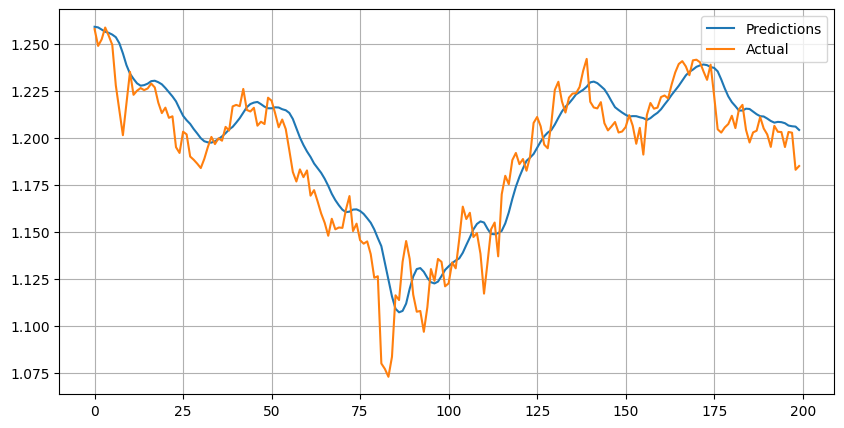

In [76]:
plot_predictions(model, X_test, y_test, start=0, end=200)

In [77]:
mae(y_test, model.predict(X_test))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.008307713164264992